In [1]:
#importing libraries
import numpy as np
from hottbox.core import Tensor
import yfinance as yf
import alphalens
import pandas as pd
from hottbox.pdtools import tensor_to_pd, pd_to_tensor
from hottbox.utils.generation import residual_tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error, mse, rmse, mape
from hottbox.rank import rank_estimation as re
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

# set the number of assets
num_assets = 20

In [47]:
# downloading stocks data from SimFin API between the start and end date
pan = yf.download("GOOG AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-20", end="2019-05-21")

# computing the returns from the adjusted closing price
returns = pan["Adj Close"].apply(np.log).diff(1)
returns = returns.stack()
returns.index = returns.index.set_names(['date', 'asset'])
returns = returns.unstack()
returns = returns.stack()
returns

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.015716
            ADBE    -0.002828
            AMAT    -0.016890
            AMD     -0.002318
            AMZN    -0.000755
                       ...   
2019-05-20  TSLA    -0.027236
            TXN     -0.019479
            V       -0.003786
            VZ       0.015714
            XLNX    -0.036255
Length: 40240, dtype: float64

In [3]:
# downloading stocks data from SimFin API between the start and end date
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-21", end="2019-05-21")

# volume
vol = pan["Volume"]
vol = vol.stack()
vol.index = vol.index.set_names(['date', 'asset'])
vol = vol.unstack()
vol = vol.stack()
vol

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     337968400
            ADBE       3246700
            AMAT      17189500
            AMD       16694300
            AMZN       3381000
                       ...    
2019-05-20  TSLA     102631000
            TXN        7519900
            V          4747400
            VZ        20910600
            XLNX      10459300
Length: 40240, dtype: int64

In [4]:
# downloading stocks data from SimFin API between the start and end date
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-14", end="2019-05-21")

# 5-day predictive factor
predictive_factor = pan['Open']
predictive_factor = -predictive_factor.pct_change(5)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

pricing = pan['Open'].iloc[1:]
pricing.index = pricing.index.tz_localize('UTC')

predictive_factor = predictive_factor.unstack()
predictive_factor = predictive_factor.stack()

predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     0.017647
            ADBE     0.008112
            AMAT     0.050532
            AMD      0.038117
            AMZN     0.037676
                       ...   
2019-05-20  TSLA     0.125900
            TXN      0.055693
            V       -0.039188
            VZ      -0.042842
            XLNX     0.113267
Length: 40240, dtype: float64

In [5]:
# downloading stocks data from SimFin API between the start and end date
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")

# 10-day non-predictive factors
non_predictive_factor = pan["Open"].pct_change(10)
non_predictive_factor = non_predictive_factor.stack()
non_predictive_factor.index = non_predictive_factor.index.set_names(['date', 'asset'])
non_predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.028969
            ADBE     0.064226
            AMAT    -0.062377
            AMD     -0.046667
            AMZN    -0.005776
                       ...   
2019-05-20  TSLA    -0.188865
            TXN     -0.096653
            V        0.032488
            VZ       0.040824
            XLNX    -0.121826
Length: 40240, dtype: float64

In [6]:
# downloading stocks data from SimFin API between the start and end date
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")

# 10-day Momentum
momentum = pan["Adj Close"].pct_change(10)
momentum = momentum.stack()
momentum.index = momentum.index.set_names(['date', 'asset'])
momentum

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.033000
            ADBE     0.057186
            AMAT    -0.074852
            AMD     -0.033632
            AMZN     0.005314
                       ...   
2019-05-20  TSLA    -0.195739
            TXN     -0.096064
            V        0.008882
            VZ       0.036901
            XLNX    -0.146862
Length: 40240, dtype: float64

In [7]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')
# Seaborn set plotting style.
sns.set_style("whitegrid")

# We are interested in the US stock-market.
market = 'us'

# List of tickers we want. If None then all tickers are used.
tickers = sorted(["GOOG","AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

hub = sf.StockHub(market=market, tickers=tickers, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices,
                 )

df_val_signals_daily = hub.val_signals(variant='daily')

Dataset "us-shareprices-daily" on disk (5 days old).
- Loading from disk ... Done!
Dataset "us-income-ttm" on disk (18 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (18 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (18 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-4c3c6a0f.pickle' on disk (5 days old).
- Loading from disk ... Done!


In [8]:
# Price to book ratio extracted from the SimFin stocks hub
df_pbv = pd.DataFrame()
for i in tickers:
    df_pbv[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Price to Book Value"]
df_pbv.fillna(0,inplace=True)

df_pbv = df_pbv.stack()
df_pbv.index = df_pbv.index.set_names(['date', 'asset'])
df_pbv = df_pbv.unstack()
df_pbv = df_pbv.stack()
pbv = df_pbv.fillna(0)
df_pbv

date        asset
2011-05-20  AAPL      5.689950
            ADBE      3.387547
            AMAT      0.000000
            AMD       6.237374
            AMZN     13.197028
                       ...    
2019-05-20  TSLA      6.081886
            TXN      11.527985
            V        13.255717
            VZ        4.456760
            XLNX      9.745485
Length: 40240, dtype: float64

In [9]:
# Market Capitalisation extracted from the SimFin stocks hub
df_mc = pd.DataFrame()
for i in tickers:
    df_mc[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Market-Cap"]
df_mc.fillna(0,inplace=True)

df_mc = df_mc.stack()
df_mc.index = df_mc.index.set_names(['date', 'asset'])
df_mc = df_mc.unstack()
df_mc = df_mc.stack()
df_mc

date        asset
2011-05-20  AAPL     3.110468e+11
            ADBE     1.837882e+10
            AMAT     0.000000e+00
            AMD      6.318460e+09
            AMZN     9.058440e+10
                         ...     
2019-05-20  TSLA     3.501731e+10
            TXN      1.036827e+11
            V        4.519537e+11
            VZ       2.438293e+11
            XLNX     2.570074e+10
Length: 40240, dtype: float64

In [10]:
# Price to Equity ratio extracted from the SimFin stocks hub
df_pe = pd.DataFrame()
for i in tickers:
    df_pe[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["P/E"]
df_pe.fillna(0,inplace=True)

df_pe = df_pe.stack()
df_pe.index = df_pe.index.set_names(['date', 'asset'])
df_pe = df_pe.unstack()
df_pe = df_pe.stack()
df_pe

date        asset
2011-05-20  AAPL     18.693842
            ADBE     20.834900
            AMAT      0.000000
            AMD      13.414989
            AMZN     78.632292
                       ...    
2019-05-20  TSLA    -35.875045
            TXN      18.581129
            V        42.018751
            VZ       15.702558
            XLNX     31.552038
Length: 40240, dtype: float64

In [11]:
# adding all the stocks data to a dataframe
data = {'Date': list(returns.index.get_level_values('date')),
        'Asset': list(returns.index.get_level_values('asset')),
        'Returns': returns,
        'Volume': vol,
        'Predictive_Factor': predictive_factor,
        'Non_Predictive_Factor': non_predictive_factor,
        'Momentum': momentum,
        'Price_to_Book_Value': df_pbv.fillna(0),
        'Market_Cap': df_mc.fillna(0),
        'P/E': df_pe.fillna(0)
       }

df_original = pd.DataFrame({'Date': data['Date'], 'Asset': data['Asset'],'Returns': data['Returns'].values, 'Volume': data['Volume'].values, 'Predictive Factor': data['Predictive_Factor'].values, 'Non-Predictive Factor': data['Non_Predictive_Factor'].values, 'Momentum': data['Momentum'].values, 'Price to book Value': data['Price_to_Book_Value'].values,'Market Cap': data['Market_Cap'].values,'P/E': data['P/E'].values })
df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']] = StandardScaler().fit_transform(df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']])
df_original

,Date,Asset,Returns,Volume,Predictive Factor,Non-Predictive Factor,Momentum,Price to book Value,Market Cap,P/E
0,2011-05-20,AAPL,-0.810748,4.168957,0.481235,-0.585197,-0.658513,-0.139992,0.700790,-0.057583
1,2011-05-20,ADBE,-0.173145,-0.364517,0.269450,0.889325,0.762768,-0.335640,-0.730837,-0.048815
2,2011-05-20,AMAT,-0.868855,-0.175676,1.211605,-1.113785,-1.318079,-0.623497,-0.820739,-0.134140
3,2011-05-20,AMD,-0.147891,-0.182383,0.935859,-0.865218,-0.668475,-0.093475,-0.789831,-0.079201
4,2011-05-20,AMZN,-0.070578,-0.362698,0.926078,-0.218245,-0.054706,0.497923,-0.377633,0.187881
...,...,...,...,...,...,...,...,...,...,...
40235,2019-05-20,TSLA,-1.380690,0.981545,2.885535,-3.115083,-3.223191,-0.106688,-0.649447,-0.281058
40236,2019-05-20,TXN,-0.996915,-0.306641,1.326232,-1.656099,-1.652367,0.356096,-0.313561,-0.058045
40237,2019-05-20,V,-0.220526,-0.344192,-0.781094,0.387177,0.001531,0.502910,1.390056,0.037939
40238,2019-05-20,VZ,0.744173,-0.125277,-0.862245,0.519055,0.443085,-0.244783,0.371986,-0.069833


In [12]:
# Converting the dataframe to a tensor
tensor = []
tensor_date = []
for i in range(len(df_original.loc[:,'Asset'])):
    if len(tensor_date)==len(tickers):
        tensor.append(tensor_date) 
        tensor_date = []
        
    tensor_date.append([df_original.loc[:,'Returns'].values[i], df_original.loc[:,'Volume'].values[i], df_original.loc[:,'Predictive Factor'].values[i], df_original.loc[:,'Non-Predictive Factor'].values[i], df_original.loc[:,'Momentum'].values[i], df_original.loc[:,'Price to book Value'].values[i], df_original.loc[:,'Market Cap'].values[i], df_original.loc[:,'P/E'].values[i]])  
    
    

In [13]:
# printng the tensor
np.array(tensor)

array([[[-8.10748490e-01,  4.16895682e+00,  4.81234908e-01, ...,
         -1.39992429e-01,  7.00790198e-01, -5.75831094e-02],
        [-1.73145036e-01, -3.64517363e-01,  2.69449957e-01, ...,
         -3.35639705e-01, -7.30836528e-01, -4.88148866e-02],
        [-8.68855095e-01, -1.75675935e-01,  1.21160491e+00, ...,
         -6.23497255e-01, -8.20739108e-01, -1.34139522e-01],
        ...,
        [-9.16963941e-01, -1.75317019e-01,  2.72517890e-01, ...,
         -2.20136248e-01, -2.27615748e-01,  2.67163327e-02],
        [-2.59119417e-01, -2.64450151e-01,  2.43231469e-01, ...,
         -5.20596638e-01, -3.05913745e-01,  3.49507304e-02],
        [-4.32721935e-01, -3.62254159e-01,  2.42414348e-01, ...,
         -2.46475821e-01, -7.73564416e-01, -7.14850104e-02]],

       [[-1.54432783e-01,  4.78699168e+00,  6.93646109e-01, ...,
         -1.41204220e-01,  6.96976842e-01, -5.77749801e-02],
        [-1.28184801e+00, -3.59660481e-01,  3.48496285e-01, ...,
         -3.42813725e-01, -7.33077090e

In [14]:
# print shape of the tensor
tensor_data = Tensor(np.array(tensor))
print(tensor_data)

This tensor is of order 3 and consists of 321760 elements.
Sizes and names of its modes are (2011, 20, 8) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Training

In [15]:
# applying CPD algorithm
alg = CPD()
alg

CPD(epsilon=0.01, init='svd', max_iter=50, random_state=None, tol=0.0001,
    verbose=False)

In [16]:
# fixing the kruksal rank and decomposing the tensor using CPD method
kruskal_rank = (100,)

tensor_cpd = alg.decompose(tensor_data, rank=kruskal_rank)
print("\tOutput of the {} algorithm:".format(alg.name))
print(tensor_cpd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_cpd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_cpd.core)
# tensor_cpd.core.data

	Output of the CPD algorithm:
Kruskal representation of a tensor with rank=(100,).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (2011, 20, 8) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (2011, 100)
Mode-1 factor matrix is of shape (20, 100)
Mode-2 factor matrix is of shape (8, 100)

	Core tensor
This tensor is of order 3 and consists of 1000000 elements.
Sizes and names of its modes are (100, 100, 100) and ['mode-0', 'mode-1', 'mode-2'] respectively.


In [17]:
# print the factor tensors
print('\n\Factor tensor')
for mode, fmat in enumerate(tensor_cpd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
tensor_cpd.fmat


\Factor tensor
Mode-0 factor matrix is of shape (2011, 100)
Mode-1 factor matrix is of shape (20, 100)
Mode-2 factor matrix is of shape (8, 100)


[array([[-0.00509127, -0.19266996, -0.01996347, ...,  0.36621993,
          0.2420542 ,  0.12357679],
        [ 0.13302404, -0.21788427, -0.08450831, ...,  0.37211135,
          0.29636726,  0.28448095],
        [ 0.06733084,  0.0438596 ,  0.00880666, ...,  0.08458725,
          0.07645813,  0.22734075],
        ...,
        [-0.03677864, -0.57166928, -0.3745959 , ...,  0.49997594,
         -0.08795472,  0.15536973],
        [-0.28876207, -0.60189946, -0.30218447, ..., -0.02541247,
          0.32373985,  0.64269334],
        [ 0.2000488 ,  0.09474101, -0.24097531, ..., -0.17160324,
         -0.10477253,  1.03999436]]),
 array([[ 0.48846943,  2.26487926,  1.91725222, ...,  0.58997637,
         -0.45985374,  1.65291166],
        [ 0.13966952,  0.66431377, -1.34791313, ..., -0.37057975,
          0.1213246 ,  0.09300019],
        [-0.01577426,  0.33336664, -0.42752303, ..., -0.59385207,
         -0.32754522, -0.34417752],
        ...,
        [ 0.35052347,  0.37808429,  0.14005883, ...,  

In [18]:
# converting the asset feature matrix (2nd factor matrix) into a dataframe
index = sorted(["GOOGL", "AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])
df = pd.DataFrame(tensor_cpd.fmat[1], columns = [i for i in range(tensor_cpd.fmat[1].shape[1])], index = index)
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
AAPL,0.488469,2.264879,1.917252,1.018082,0.055655,1.887599,-1.567303,-1.276081,-0.836780,-1.098723,...,0.097266,-1.126722,0.484476,0.084781,-1.278831,-0.304471,2.276964,0.589976,-0.459854,1.652912
ADBE,0.139670,0.664314,-1.347913,-0.395644,0.350650,0.239737,0.130485,-0.371014,0.077892,-0.089341,...,0.686323,-0.176697,-0.573045,0.567411,-0.298841,0.602280,0.377732,-0.370580,0.121325,0.093000
AMAT,-0.015774,0.333367,-0.427523,-0.032514,-0.199774,0.213790,-0.464687,-0.244101,0.618499,0.004749,...,0.774289,0.229008,-0.440123,0.745465,0.137428,-0.174662,0.503512,-0.593852,-0.327545,-0.344178
AMD,-3.275577,-1.134520,-2.112919,-2.140565,2.793558,-0.960360,0.568357,0.212314,-1.851127,-1.925659,...,0.682049,-0.124082,-0.495316,0.098767,-0.029475,1.334907,0.025336,-1.031492,-1.808108,1.604558
AMZN,0.276599,1.538434,3.531873,-0.261446,1.315310,-0.729903,-0.664625,-0.736964,-1.157983,-0.104500,...,0.956157,-0.262689,-1.644738,0.767444,1.591050,-0.141314,0.021796,0.699490,-2.690300,1.050521
CSCO,0.105919,0.561470,-0.304268,-0.337294,0.282067,-0.146312,0.227893,-1.227154,-0.195963,-0.531056,...,-2.258450,-0.148180,-0.129942,-0.752816,-0.781445,-0.150341,1.939418,0.887686,1.766287,-0.523757
GOOGL,0.273990,0.523321,-1.888222,0.276078,-0.090399,0.547150,0.123706,-0.934080,0.108588,-0.774403,...,1.428613,0.011306,-0.011604,1.318276,1.728672,0.249196,0.167922,0.011659,0.070520,0.877766
HPQ,0.061969,0.569063,-0.624788,-0.947321,-4.259398,-1.467307,-2.248327,-0.741011,0.072855,-0.891278,...,0.353510,0.206487,1.524325,1.894050,2.479049,-0.272864,0.341538,1.354747,-1.008343,-0.022276
IBM,0.236429,0.071444,-0.081131,-0.362745,0.002586,-0.004962,-0.175694,0.213550,-0.183603,-0.926093,...,-0.120421,-0.179459,-0.537600,-0.731825,0.601255,-0.107071,0.246068,0.841429,0.178642,0.044057
INTC,0.055673,-1.628221,-0.625100,-0.250523,-0.223318,0.132111,-0.260008,-0.455657,-0.235414,0.450009,...,0.280477,-0.379390,-0.672960,0.489764,0.302605,0.075056,0.222809,-0.119099,-0.362481,0.383453


0.10160554083746125
-0.10298200035214818
-0.08821705056680465
-0.030420229386564617
-0.07243760033792558
-0.0005741959880082581
-0.10765072246668873
-0.1536575300260086
0.0021635783181692602
-0.0815383150364946
-0.052138072724022246
0.24537467790345302
-0.04553356605111866
0.044131997654198056
-0.0664857308813769
0.11850283327651848
-0.06640329020267333
-0.031363967404254164
-0.033021461580836145
-0.07481284704708789


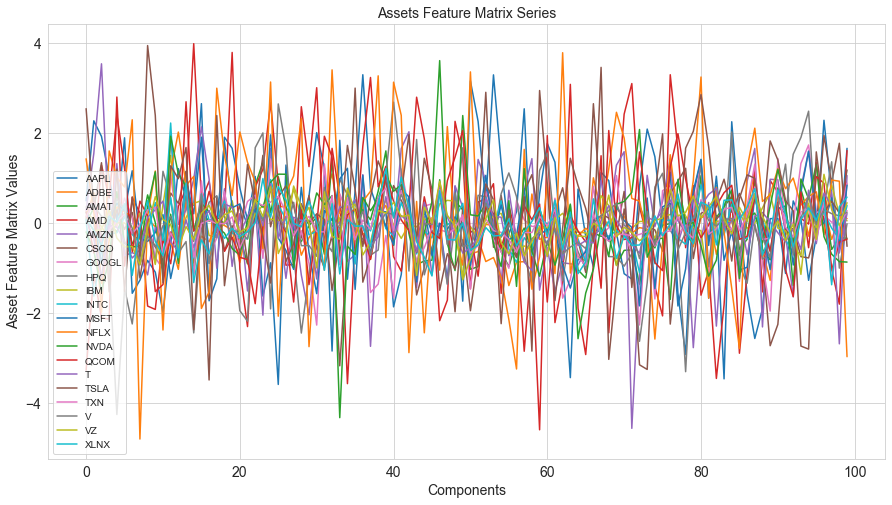

In [20]:
# plotting the assets feature matrix to check for stationarity
fig,ax=plt.subplots(1)
for i in index:
    df.loc[i,:].plot(ax=ax,fontsize=14)
    print(df.loc[i,:].mean())

ax.legend(index)
ax.set_title("Assets Feature Matrix Series",fontsize=14)
ax.set_ylabel('Asset Feature Matrix Values', fontsize=14)
ax.set_xlabel('Components', fontsize=14)
fig.set_size_inches(15, 8) 

## PCA

In [21]:
# applying PCA on the assets feature matrix and printing the first principal component
from sklearn.decomposition import PCA
pca = PCA(1).fit(df.transpose())
pca.components_[0]

array([ 4.56149107e-02, -4.95338189e-02, -3.39141004e-02, -9.01543542e-01,
       -1.33978603e-01,  9.64154262e-02,  6.07765532e-04,  1.06329017e-01,
       -7.29674692e-03, -1.59935016e-02, -4.91011782e-02, -1.39817928e-01,
       -1.73203801e-01, -1.08120664e-01,  2.30129018e-02,  2.75714241e-01,
       -2.07672689e-02, -5.55170897e-03,  4.40260487e-02,  8.68031429e-03])

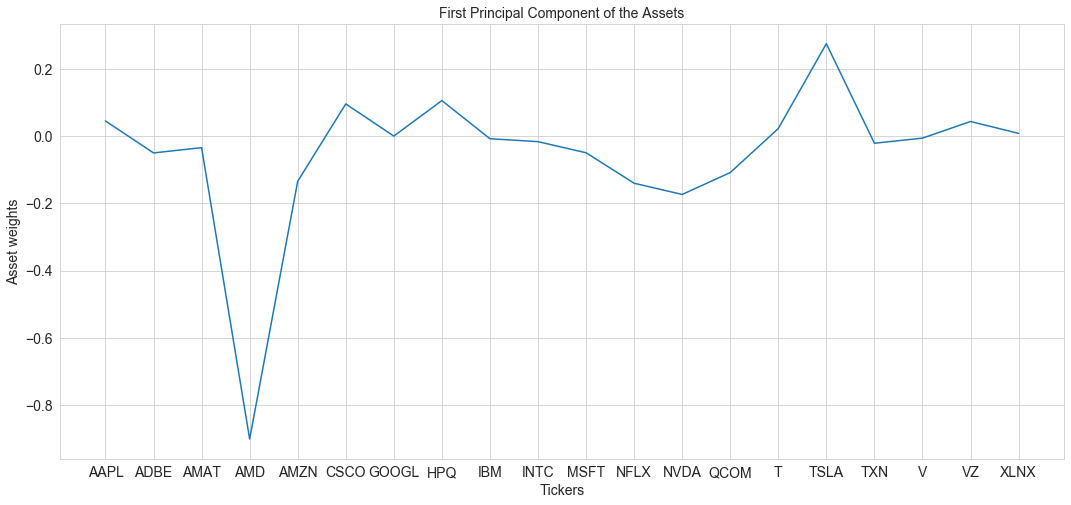

In [22]:
# plotting the sset weights for the first principal component
fig, axes = plt.subplots(1)
pc1 = pd.Series(index=index, data=pca.components_[0])
pc1.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='First Principal Component of the assets',fontsize=14)
axes.set_ylabel('Asset weights', fontsize=14)
axes.set_xlabel('Tickers', fontsize=14)
axes.set_title('First Principal Component of the Assets',fontsize=14)
fig.set_size_inches(18, 8) 

In [23]:
# sorting asset weights
pc1.sort_values()

AMD     -0.901544
NVDA    -0.173204
NFLX    -0.139818
AMZN    -0.133979
QCOM    -0.108121
ADBE    -0.049534
MSFT    -0.049101
AMAT    -0.033914
TXN     -0.020767
INTC    -0.015994
IBM     -0.007297
V       -0.005552
GOOGL    0.000608
XLNX     0.008680
T        0.023013
VZ       0.044026
AAPL     0.045615
CSCO     0.096415
HPQ      0.106329
TSLA     0.275714
dtype: float64

Text(0.5, 1.0, 'Top 10 assets')

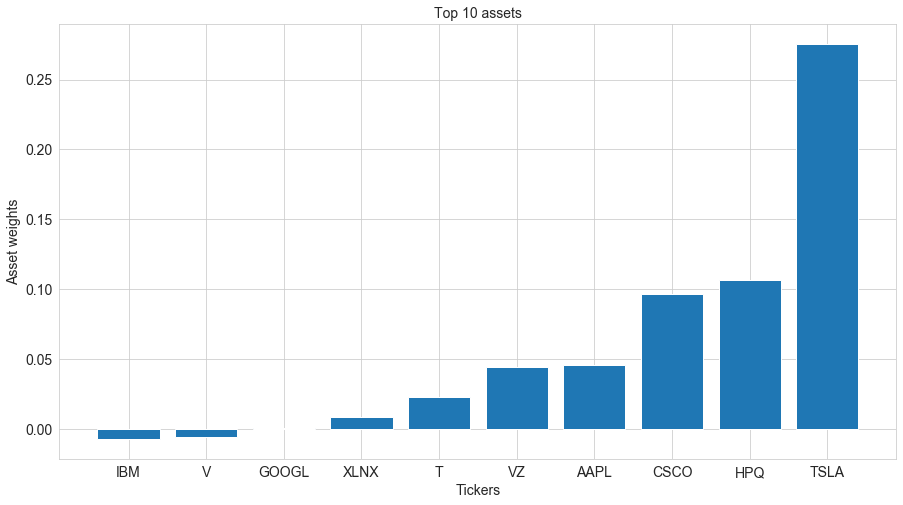

In [24]:
# plotting the asset weights for the top 10 assets
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(15, 8))
plt.bar(pc1.sort_values().index[-10:],pc1.sort_values().values[-10:])
plt.ylabel('Asset weights', fontsize=14)
plt.xlabel('Tickers', fontsize=14)
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)
plt.title("Top 10 assets",fontsize=14)

## ICA

In [25]:
# applying ICA on the the assets feature matrix
from sklearn.decomposition import FastICA
ica = FastICA(n_components=10,random_state=0).fit(df.transpose().fillna(0))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


[*********************100%***********************]  20 of 20 completed


Text(0.5, 1.0, 'Independent Components')

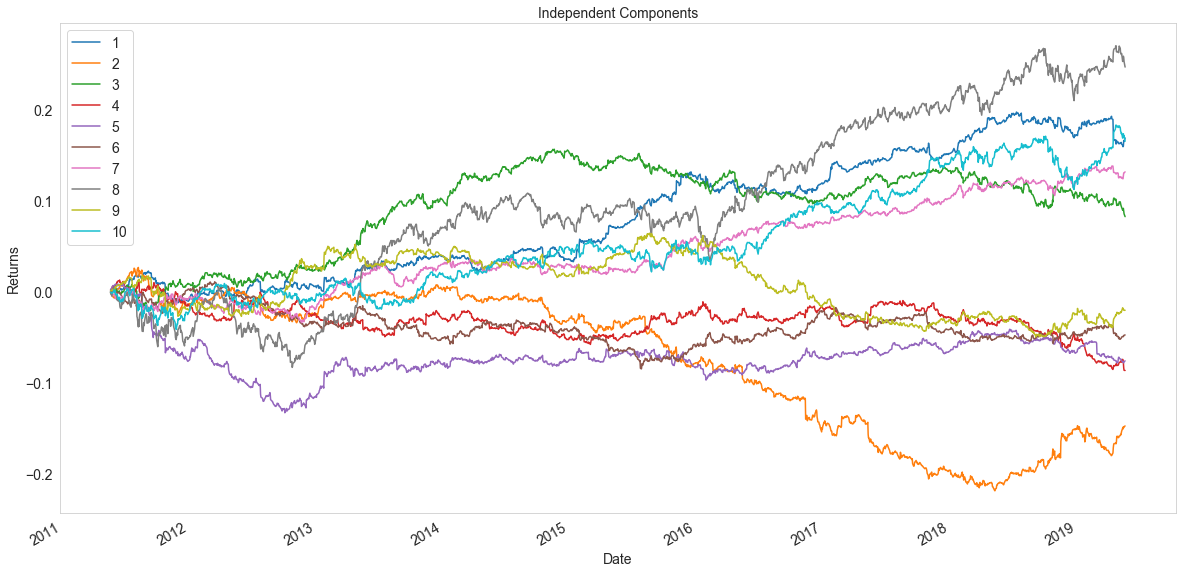

In [26]:
# identifying the dominant independent component from the returns series
fig, ax = plt.subplots(1, figsize=(20, 10)) 
pan = yf.download(tickers, start="2011-05-20", end="2019-05-21")
ret = pan["Adj Close"].apply(np.log).diff(1)
for i in range(10):
    ret.dot(ica.components_[i]).cumsum().plot(ax=ax,fontsize=14)
ax.legend([str(i) for i in range(1,11,1)],fontsize=14)
ax.grid()
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title("Independent Components",fontsize=14)

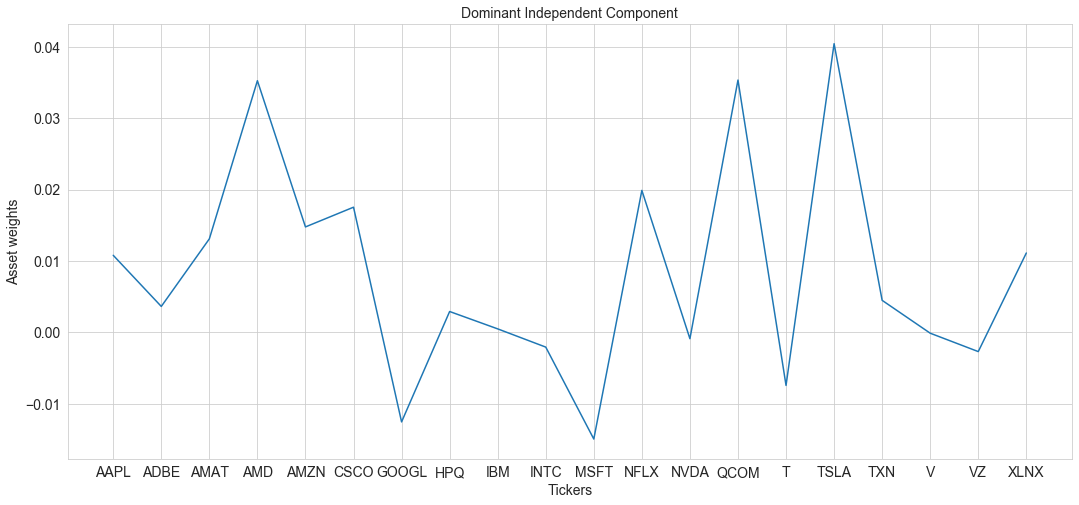

In [27]:
# plotting the asset weights for the dominant independent component
dominant_ica = 7 # change according to the figure above
fig, axes = plt.subplots(1)
ica_tech = pd.Series(index=df.transpose().columns, data=ica.components_[dominant_ica])
ica_tech.plot(ax=axes, xticks=np.arange(0, num_assets, 1.0),  title='Dominant Independent Component',fontsize=14)
axes.set_ylabel('Asset weights', fontsize=14)
axes.set_xlabel('Tickers', fontsize=14)
axes.set_title('Dominant Independent Component',fontsize=14)
fig.set_size_inches(18, 8) 

In [28]:
# sorting the asset weights
ica_tech.sort_values()

MSFT    -0.014917
GOOGL   -0.012518
T       -0.007409
VZ      -0.002673
INTC    -0.002046
NVDA    -0.000870
V       -0.000098
IBM      0.000507
HPQ      0.002938
ADBE     0.003649
TXN      0.004500
AAPL     0.010808
XLNX     0.011131
AMAT     0.013111
AMZN     0.014782
CSCO     0.017543
NFLX     0.019897
AMD      0.035255
QCOM     0.035344
TSLA     0.040437
dtype: float64

Text(0.5, 1.0, 'Top 10 assets')

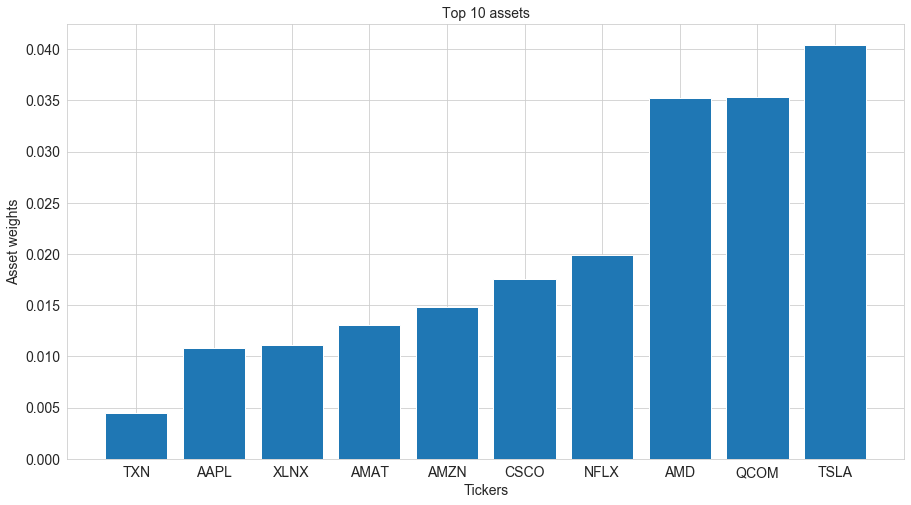

In [29]:
# plotting the asset weights for top 10 assets
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(15, 8))
plt.bar(ica_tech.sort_values().index[-10:],ica_tech.sort_values().values[-10:])
plt.ylabel('Asset weights', fontsize=14)
plt.xlabel('Tickers', fontsize=14)
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)
plt.title("Top 10 assets",fontsize=14)

# Testing

In [30]:
# downloading stocks data from SimFin API between the start and end date
test = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2019-05-19", end="2021-05-20")

# returns computed from the adjusted closing prices in the testing data
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  20 of 20 completed


date        asset
2019-05-21  AAPL     0.018989
            ADBE     0.009467
            AMAT     0.022545
            AMD      0.024802
            AMZN    -0.000780
                       ...   
2021-05-19  TSLA    -0.025253
            TXN      0.015808
            V       -0.004354
            VZ      -0.004557
            XLNX     0.024732
Length: 10080, dtype: float64

## PCA

In [31]:
# applying PCA asset weights to the returns data and computing the mean returns
mean_returns = []
for i in range(0,len(returns_test),num_assets):
    mean_returns.append(returns_test[i:i+num_assets].values.dot(abs(pca.components_[0])/sum(abs(pca.components_[0]))).mean())
# mean_returns

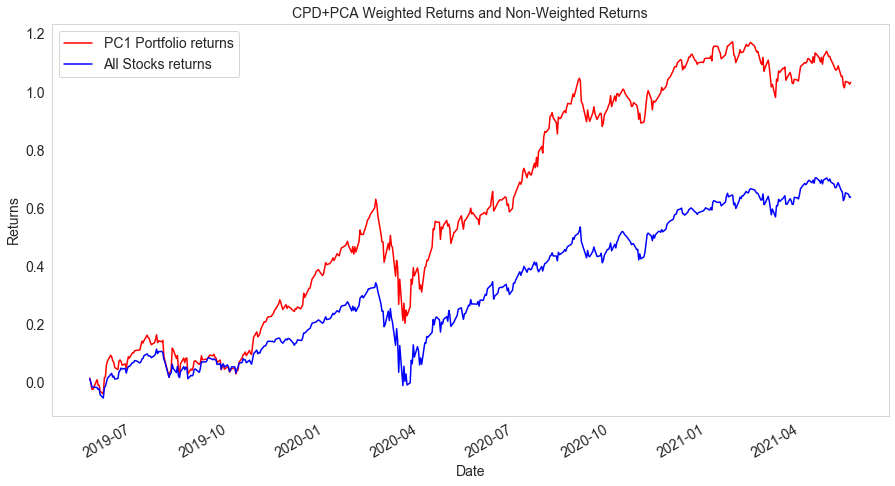

In [32]:
# plotting the PCA weighted and unweighted mean returns series 
df_pca = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))
mean_pca = test["Adj Close"].apply(np.log).diff(1).mean(1)
fig,ax = plt.subplots(1,figsize=(15, 8))
df_pca.cumsum().plot(ax=ax, style='r-')
mean_pca.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['PC1 Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("CPD+PCA Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

CPD+PCA


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,55.064%
Cumulative returns,140.448%
Annual volatility,39.257%
Sharpe ratio,1.32
Calmar ratio,1.47
Stability,0.92
Max drawdown,-37.535%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.54,2020-02-19,2020-03-18,2020-07-09,102
1,17.99,2021-01-26,2021-03-08,NaT,NaN
2,15.96,2020-09-01,2020-09-23,2020-11-30,65
3,13.84,2019-07-24,2019-08-05,2019-11-01,73
4,7.20,2020-08-06,2020-08-11,2020-08-18,9


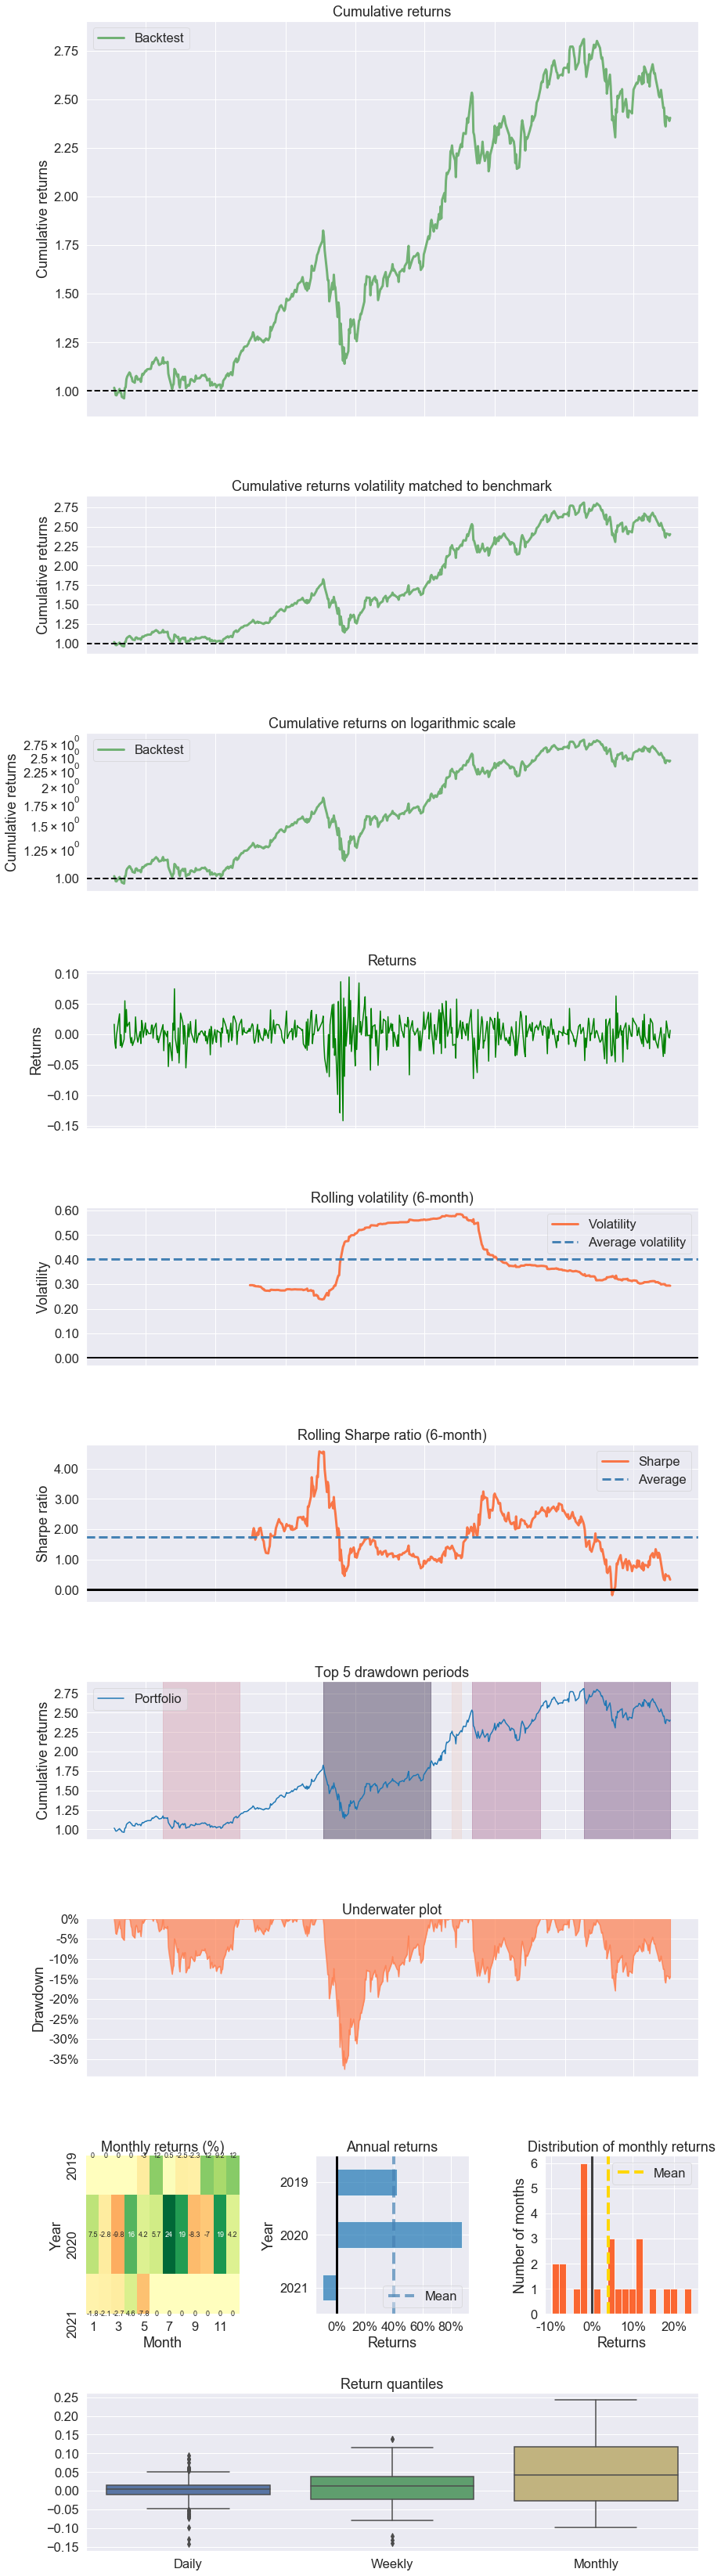

In [33]:
# PCA-weighted portfolio performance
import pyfolio as pf
print("CPD+PCA")
pf.create_returns_tear_sheet(df_pca)

## ICA

In [34]:
# applying ICA asset weights to the returns data and computing the mean returns
mean_returns = []
for i in range(0,len(returns_test),num_assets):
    mean_returns.append(returns_test[i:i+num_assets].values.dot(ica_tech).mean())
# mean_returns

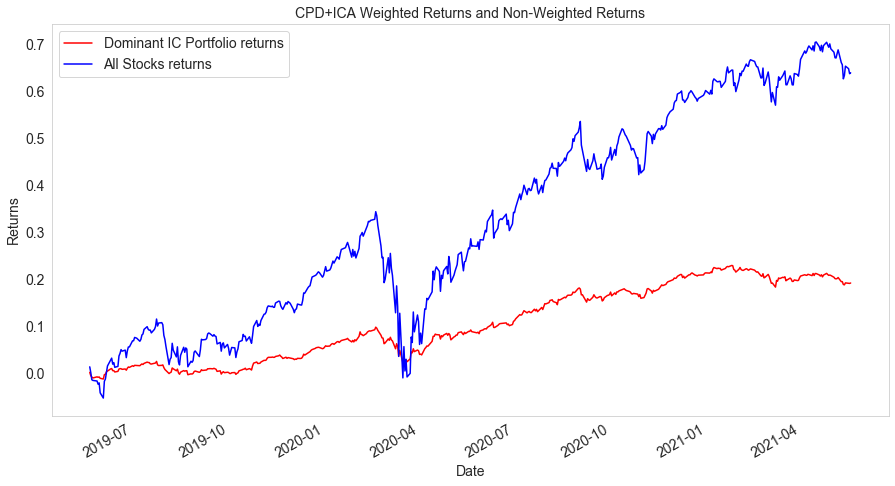

In [35]:
# plotting the ICA weighted and unweighted mean returns series 
df_ica = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))
mean_ica = test["Adj Close"].apply(np.log).diff(1).mean(1)
fig,ax = plt.subplots(1,figsize=(15, 8))
df_ica.cumsum().plot(ax=ax, style='r-')
mean_ica.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['Dominant IC Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("CPD+ICA Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

CPD+ICA


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,9.848%
Cumulative returns,20.667%
Annual volatility,6.993%
Sharpe ratio,1.38
Calmar ratio,1.24
Stability,0.93
Max drawdown,-7.93%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.93,2020-02-19,2020-03-18,2020-06-08,79
1,4.52,2021-01-25,2021-03-08,NaT,NaN
2,2.98,2020-09-01,2020-09-08,2020-11-18,57
3,2.81,2019-07-24,2019-08-23,2019-11-04,74
4,1.41,2019-05-21,2019-06-03,2019-06-06,13


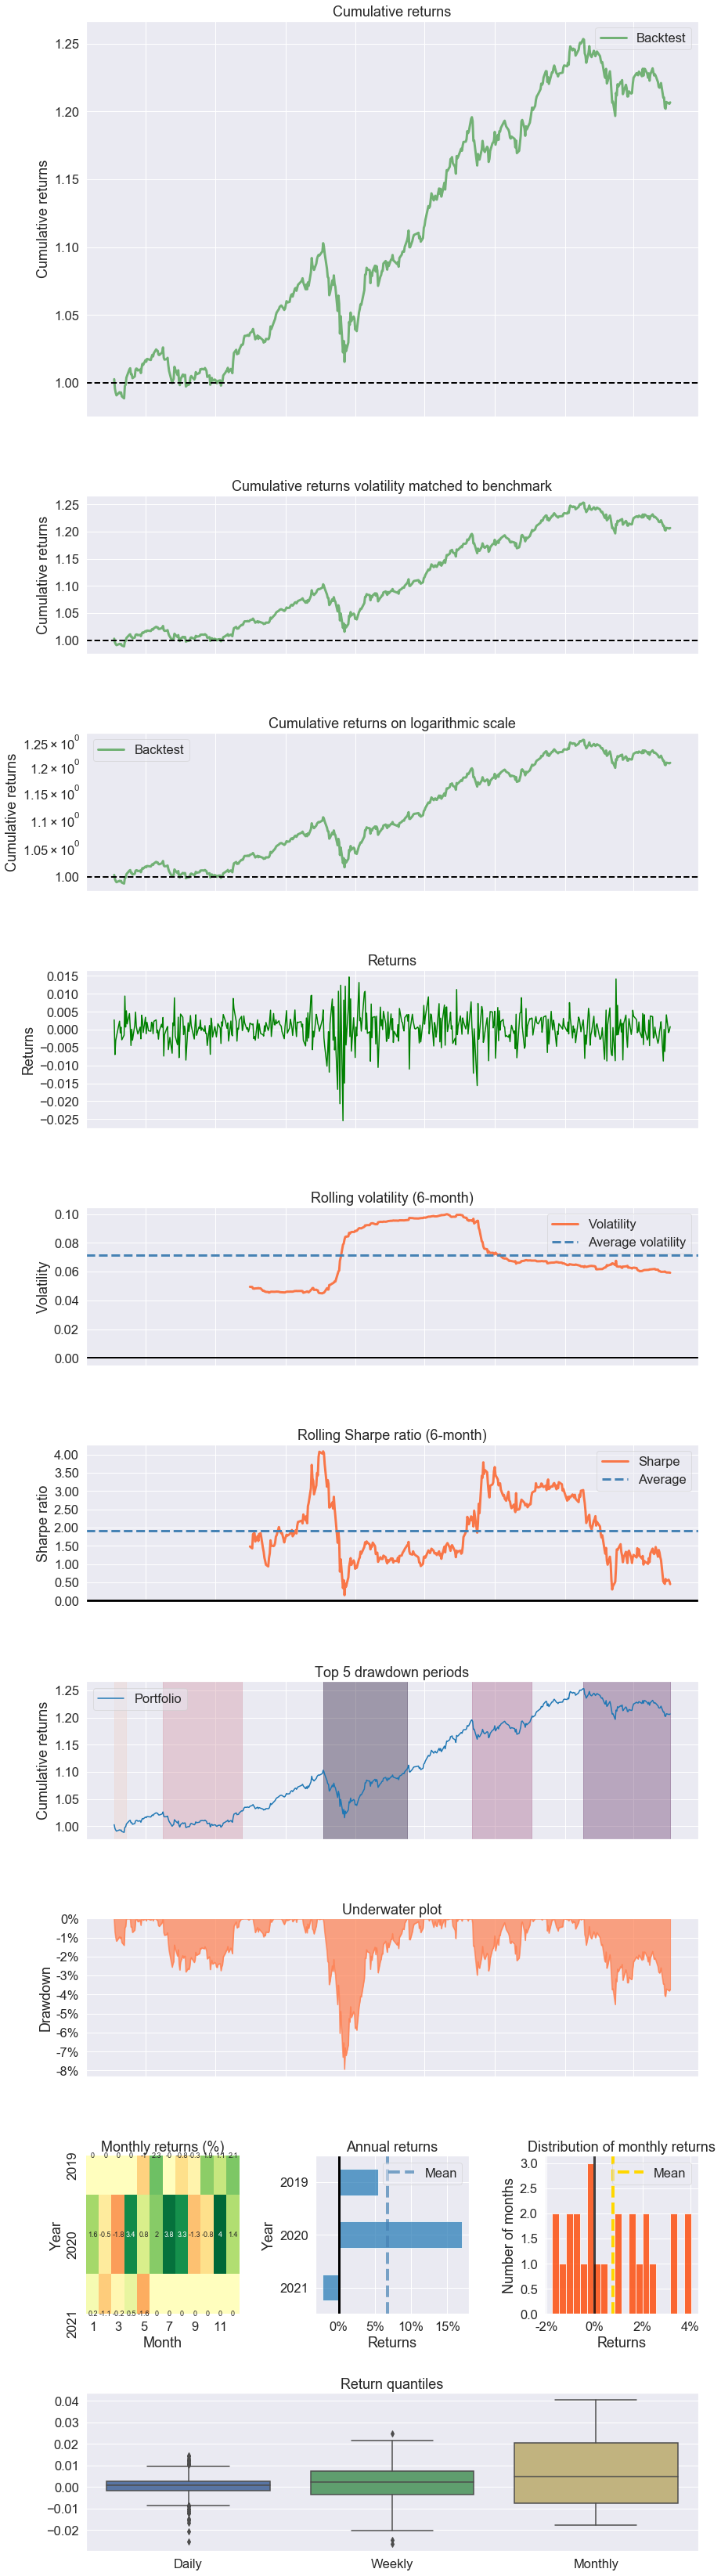

In [36]:
# ICA-weighted portfolio performance
import pyfolio as pf
print("CPD+ICA")
pf.create_returns_tear_sheet(df_ica)

## Top 10

## PCA

In [37]:
# dominant assets using PCA weights
dominant_assets = pc1.sort_values().index[-10:]
dominant_assets = " ".join(dominant_assets)
dominant_assets

'IBM V GOOGL XLNX T VZ AAPL CSCO HPQ TSLA'

In [38]:
# downloading stocks testing data from SimFin API between the start and end date
test = yf.download(dominant_assets, start="2019-05-19", end="2021-05-20")

# computing the log returns
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AAPL     0.018989
            CSCO     0.009064
            GOOGL    0.008508
            HPQ      0.025001
            IBM      0.009795
                       ...   
2021-05-19  T       -0.020168
            TSLA    -0.025253
            V       -0.004354
            VZ      -0.004557
            XLNX     0.024732
Length: 5040, dtype: float64

In [39]:
# mean returns data for 10 best PCA weighted stocks
mean_returns = []
for i in range(0,len(returns_test),10):
    mean_returns.append(returns_test[i:i+10].mean())
# mean_returns

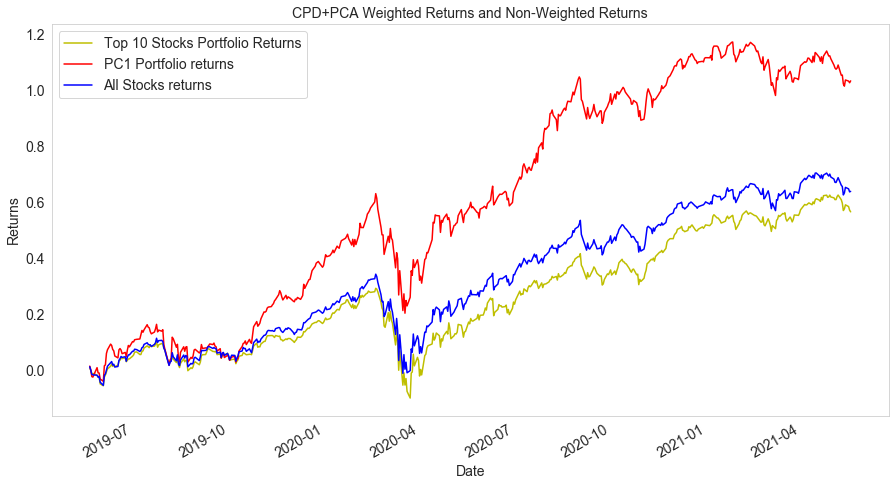

In [40]:
# plotting the top 10 PCA stocks, PCA weighted and unweighted mean returns series 
df_pca10 = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))
fig,ax = plt.subplots(1,figsize=(15, 8))
df_pca10.cumsum().plot(ax=ax, style='y-')
df_pca.cumsum().plot(ax=ax, style='r-')
mean_pca.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['Top 10 Stocks Portfolio Returns','PC1 Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("CPD+PCA Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

CPD+PCA- top 10


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,27.605%
Cumulative returns,62.83%
Annual volatility,27.97%
Sharpe ratio,1.01
Calmar ratio,0.80
Stability,0.81
Max drawdown,-34.37%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.37,2020-02-19,2020-03-23,2020-08-18,130
1,10.96,2020-09-02,2020-10-28,2020-11-19,57
2,10.13,2019-07-24,2019-08-23,2019-11-06,76
3,7.18,2021-02-08,2021-03-04,2021-04-01,39
4,6.50,2019-05-21,2019-06-03,2019-06-10,15


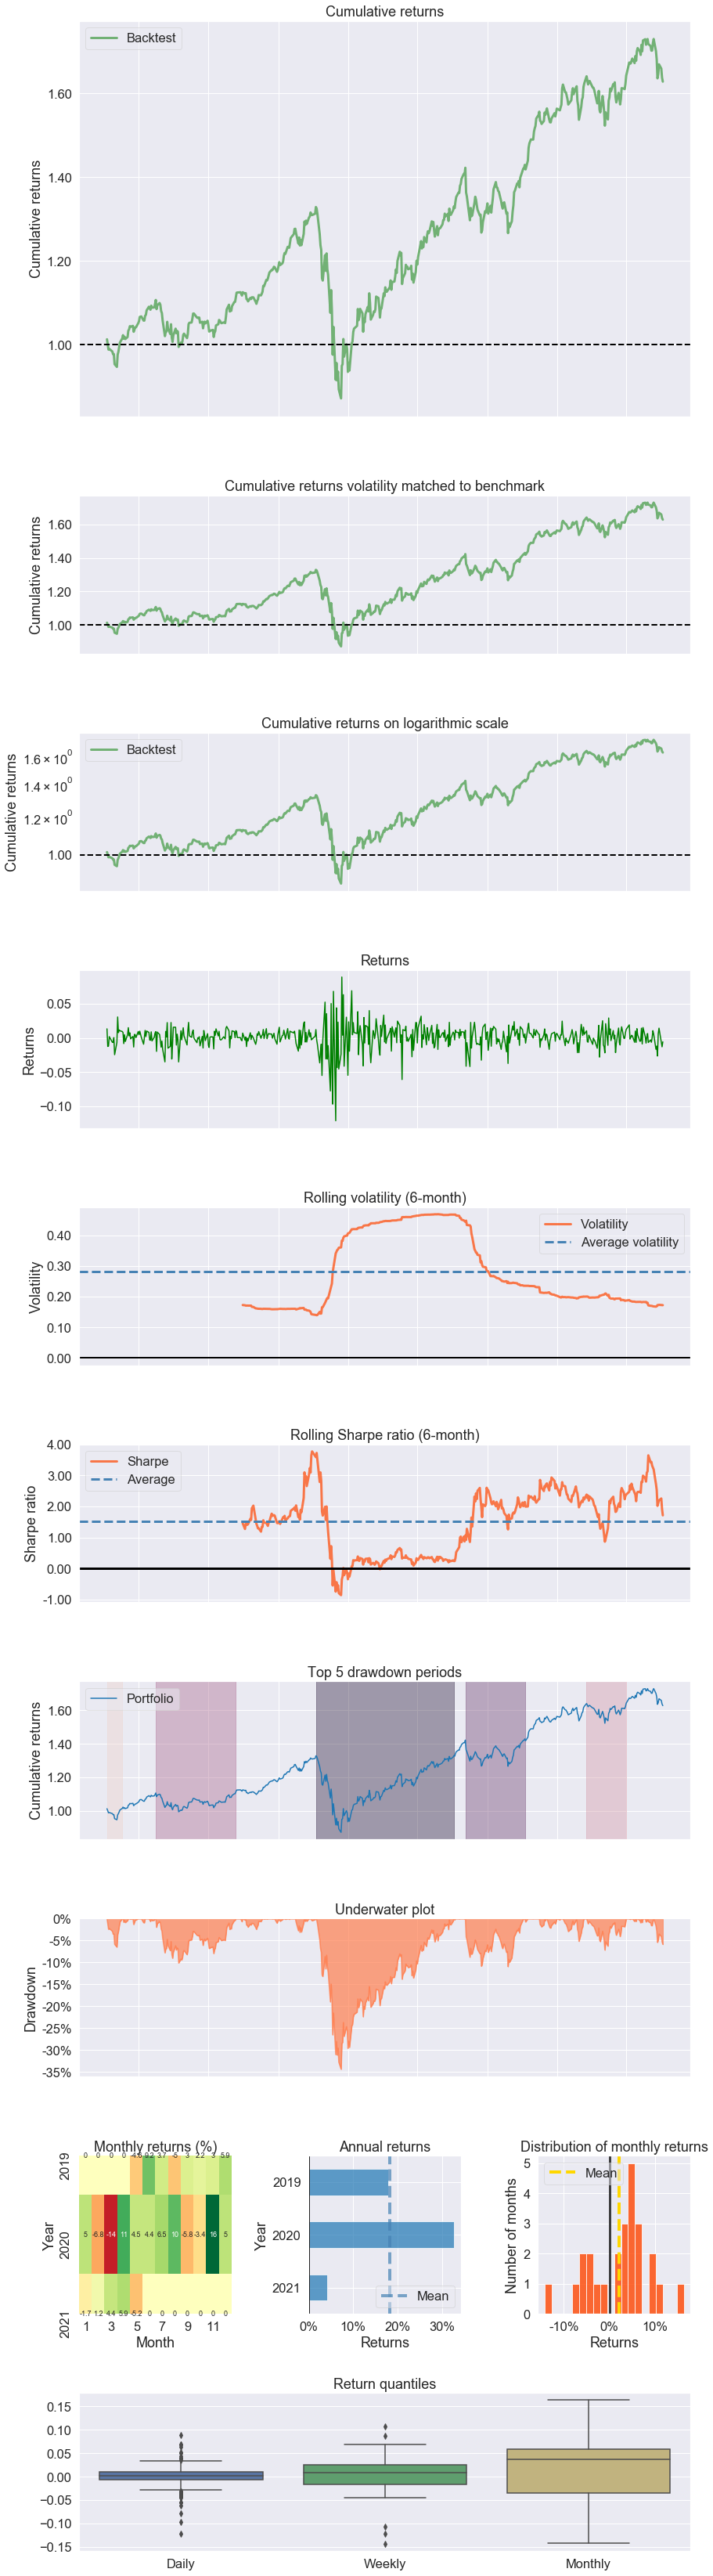

In [41]:
# top 10 PCA stocks portfolio performance
import pyfolio as pf
print("CPD+PCA- top 10")
pf.create_returns_tear_sheet(df_pca10)

## ICA

In [42]:
# dominant assets using ICA weights
dominant_assets_ica = ica_tech.sort_values().index[-10:]
dominant_assets_ica = " ".join(dominant_assets_ica)
dominant_assets_ica

'TXN AAPL XLNX AMAT AMZN CSCO NFLX AMD QCOM TSLA'

In [43]:
# downloading stocks testing data from SimFin API between the start and end date
test = yf.download(dominant_assets_ica, start="2019-05-19", end="2021-05-20")

# computing the log returns
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AAPL     0.018989
            AMAT     0.022545
            AMD      0.024802
            AMZN    -0.000780
            CSCO     0.009064
                       ...   
2021-05-19  NFLX     0.002916
            QCOM     0.013484
            TSLA    -0.025253
            TXN      0.015808
            XLNX     0.024732
Length: 5040, dtype: float64

In [44]:
# mean returns data for 10 best PCA stocks
mean_returns = []
for i in range(0,len(returns_test),10):
    mean_returns.append(returns_test[i:i+10].mean())
# mean_returns

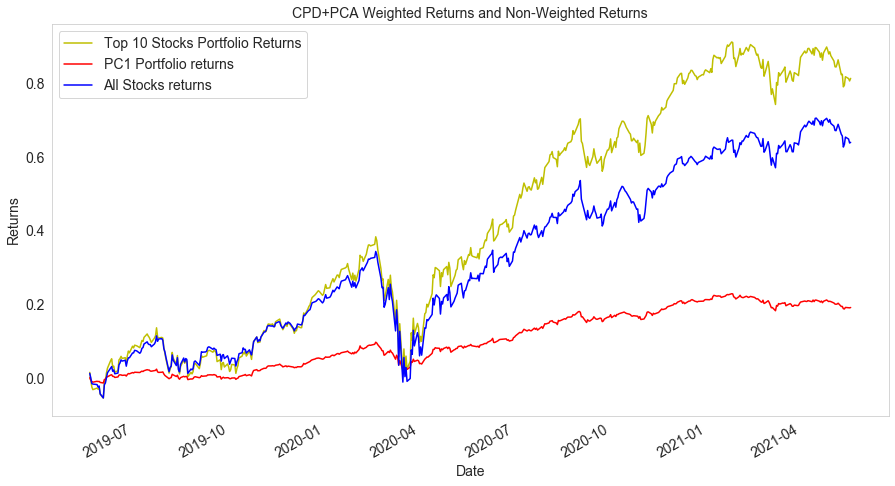

In [45]:
# plotting the top 10 ICA stocks, ICA weighted and unweighted mean returns series 
df_ica10 = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))
fig,ax = plt.subplots(1,figsize=(15, 8))
df_ica10.cumsum().plot(ax=ax, style='y-')
df_ica.cumsum().plot(ax=ax, style='r-')
mean_ica.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['Top 10 Stocks Portfolio Returns','PC1 Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("CPD+PCA Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

CPD+ICA- top 10


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,41.357%
Cumulative returns,99.817%
Annual volatility,34.502%
Sharpe ratio,1.18
Calmar ratio,1.24
Stability,0.90
Max drawdown,-33.285%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.29,2020-02-19,2020-03-16,2020-07-02,97
1,16.19,2021-01-25,2021-03-08,NaT,NaN
2,13.78,2020-09-02,2020-09-23,2020-11-18,56
3,12.84,2019-07-24,2019-08-23,2019-11-08,78
4,6.77,2019-05-21,2019-06-03,2019-06-07,14


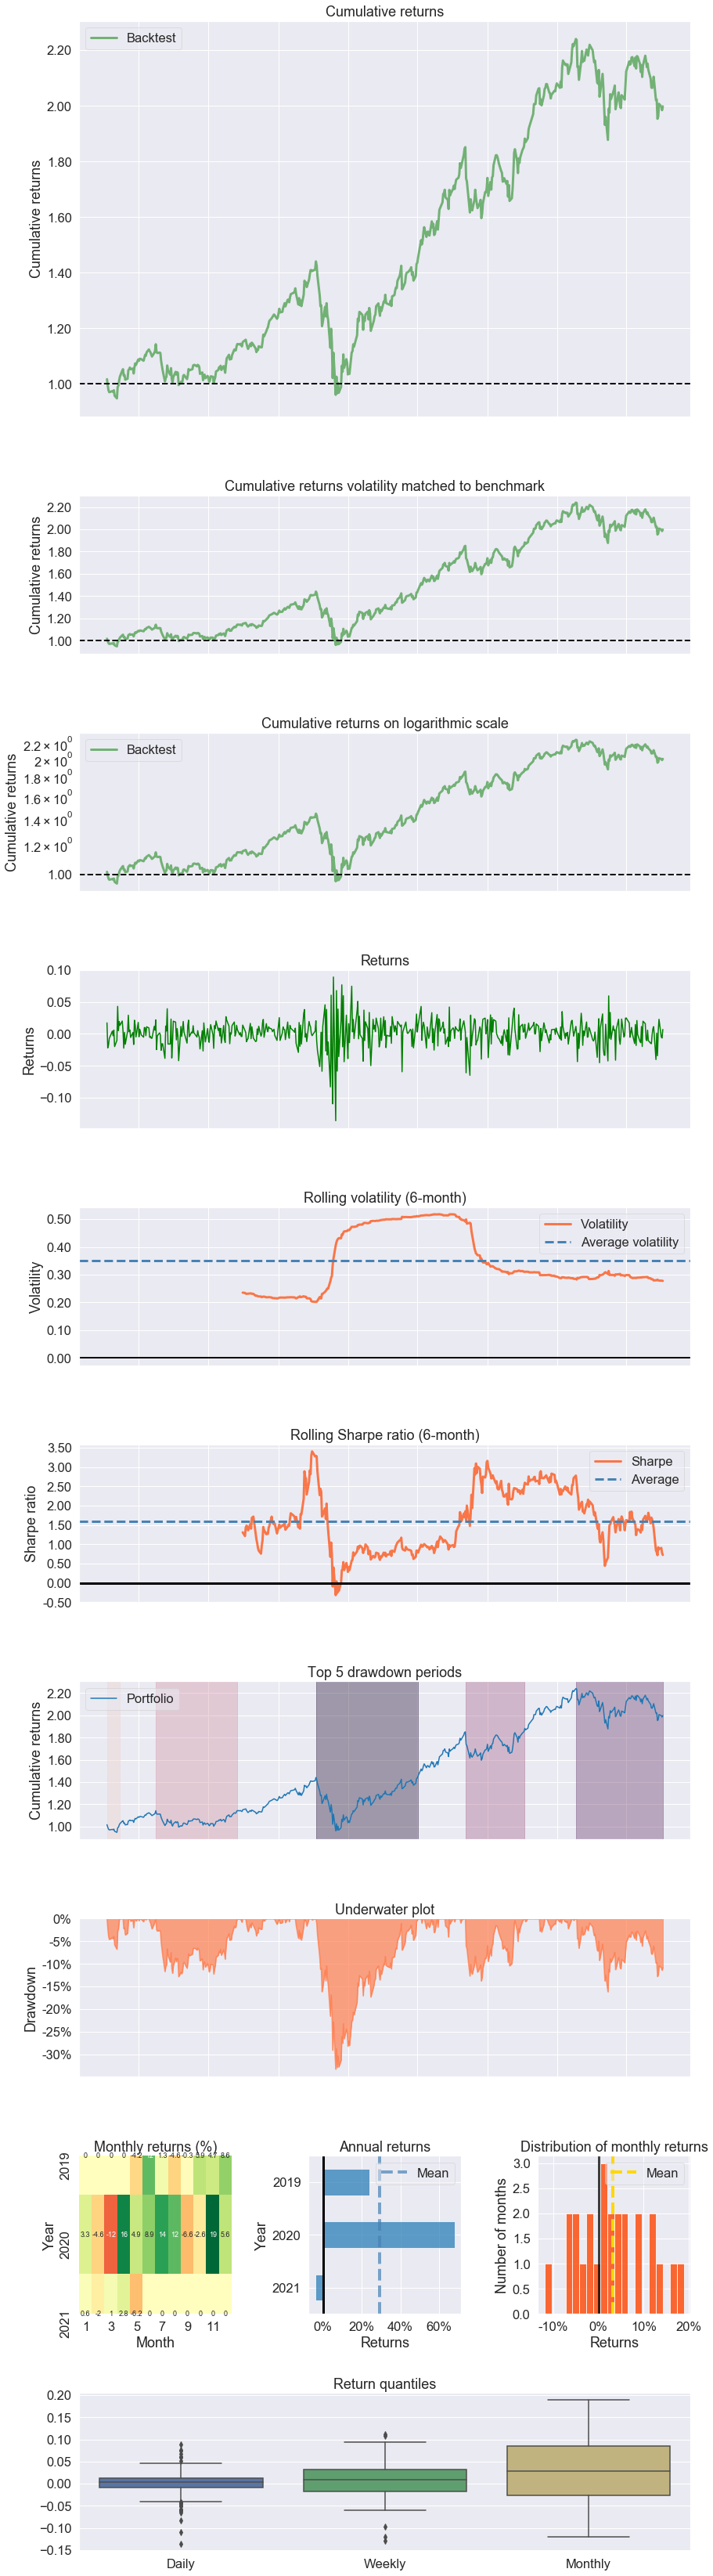

In [46]:
# top 10 ICA stocks portfolio performance
import pyfolio as pf
print("CPD+ICA- top 10")
pf.create_returns_tear_sheet(df_ica10)